In [1]:
# Import our dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Fix a random seed so the data can be reproduced
np.random.seed(24)

# Upload and read the csv files
ais_df = pd.read_csv("ml_data_daily_2018.csv", index_col=0)

In [2]:
# Look at our data
ais_df.head()

,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable
2018/01/01,9,37,145,44,27,13,12,7
2018/01/02,13,45,119,41,27,14,19,10
2018/01/03,13,44,106,40,36,14,20,11
2018/01/04,15,44,103,45,30,10,15,12
2018/01/05,10,45,107,41,26,13,21,10


In [3]:
# Creating a total column for our data
ais_df['Total']= ais_df.sum(axis=1)
ais_df.head()

,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable,Total
2018/01/01,9,37,145,44,27,13,12,7,294
2018/01/02,13,45,119,41,27,14,19,10,288
2018/01/03,13,44,106,40,36,14,20,11,284
2018/01/04,15,44,103,45,30,10,15,12,274
2018/01/05,10,45,107,41,26,13,21,10,273


In [4]:
# And then check the type
ais_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2018/01/01 to 2018/12/31
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Fishing       365 non-null    int64
 1   TugTow        365 non-null    int64
 2   Recreational  365 non-null    int64
 3   Passenger     365 non-null    int64
 4   Cargo         365 non-null    int64
 5   Tanker        365 non-null    int64
 6   Other         365 non-null    int64
 7   Unavailable   365 non-null    int64
 8   Total         365 non-null    int64
dtypes: int64(9)
memory usage: 28.5+ KB


In [5]:
# Create nine DataFrames, each with the Date and one unique column:

# Fishing
ais_fishing_df = ais_df.loc[:, ['Fishing']]

# TugTow
ais_tugtow_df = ais_df.loc[:, ['TugTow']]

# Recreational
ais_recreational_df = ais_df.loc[:, ['Recreational']]

# Passenger
ais_passenger_df = ais_df.loc[:, ['Passenger']]

# Cargo
ais_cargo_df = ais_df.loc[:, ['Cargo']]

# Tanker
ais_tanker_df = ais_df.loc[:, ['Tanker']]

# Other
ais_other_df = ais_df.loc[:, ['Other']]

# Unavailable
ais_unavailable_df = ais_df.loc[:, ['Unavailable']]

# Total
ais_total_df = ais_df.loc[:, ['Total']]

In [6]:
# From here we will be using 'Total' as an example, and repeating the code for the rest of the data

# Check the new DataFrame
ais_total_df

,Total
2018/01/01,294
2018/01/02,288
2018/01/03,284
2018/01/04,274
2018/01/05,273
...,...
2018/12/27,298
2018/12/28,298
2018/12/29,306
2018/12/30,308


In [7]:
# From here, the code is heavily inspired by the code found on this site:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [8]:
# Creating a function to automate making a model for all nine Dataframes
def BoatModel (x):
    # Convert the DataFrame into an array, and change the type to floats for the Neural Network
    data = x.values
    data = data.astype('float32')
    
    # Normalize the data by using a scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    
    # Split our data into training and testing using slicing, and check the length

    # Determin the length of what our split will be
    data_split = int(len(data) * 0.75)
    
    #Slice the data and print the results
    train, test = data[:data_split], data[data_split:]
    
    # Convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    
    # Reshape the values into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    # Reshape the data to incorperate into the LSTM
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, activation='relu', input_shape=(1, look_back)))
    model.add(Dense(2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
    es = [EarlyStopping(monitor='loss', patience=15)]
    fit_model = model.fit(trainX, trainY, epochs=100, validation_split=0.3, batch_size=1, verbose=2, callbacks=[es])
    
    # Make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    # Invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    # Calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    # And catch the results to print later
    show_trainScore = 'Train Score: %.2f RMSE' % (trainScore)
    show_testScore = 'Test Score: %.2f RMSE' % (testScore)
    
    # Shift train predictions for plotting
    trainPredictPlot = np.empty_like(data)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # Shift test predictions for plotting
    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict
    # Plot baseline and predictions
    plt.plot(scaler.inverse_transform(data))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    graph = plt.show()
  
    return fit_model, show_trainScore, show_testScore, graph

Epoch 1/100
189/189 - 1s - loss: 0.0729 - mse: 0.0729 - mae: 0.2162 - mape: 52.0264 - val_loss: 0.0339 - val_mse: 0.0339 - val_mae: 0.1436 - val_mape: 27.3492 - 1s/epoch - 7ms/step
Epoch 2/100
189/189 - 0s - loss: 0.0287 - mse: 0.0287 - mae: 0.1342 - mape: 40.2912 - val_loss: 0.0280 - val_mse: 0.0280 - val_mae: 0.1293 - val_mape: 25.8196 - 374ms/epoch - 2ms/step
Epoch 3/100
189/189 - 0s - loss: 0.0278 - mse: 0.0278 - mae: 0.1336 - mape: 40.4921 - val_loss: 0.0281 - val_mse: 0.0281 - val_mae: 0.1298 - val_mape: 25.8467 - 378ms/epoch - 2ms/step
Epoch 4/100
189/189 - 0s - loss: 0.0271 - mse: 0.0271 - mae: 0.1312 - mape: 39.4145 - val_loss: 0.0257 - val_mse: 0.0257 - val_mae: 0.1248 - val_mape: 25.5779 - 362ms/epoch - 2ms/step
Epoch 5/100
189/189 - 0s - loss: 0.0262 - mse: 0.0262 - mae: 0.1310 - mape: 40.3252 - val_loss: 0.0286 - val_mse: 0.0286 - val_mae: 0.1317 - val_mape: 25.9438 - 406ms/epoch - 2ms/step
Epoch 6/100
189/189 - 0s - loss: 0.0251 - mse: 0.0251 - mae: 0.1285 - mape: 39.0817

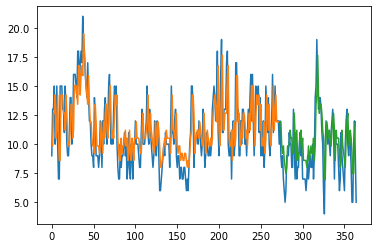

(<keras.callbacks.History at 0x25da7fd6fd0>,
 'Train Score: 2.27 RMSE',
 'Test Score: 2.17 RMSE',
 None)

In [9]:
BoatModel(ais_fishing_df)

In [ ]:
# Check the function with 'total'
BoatModel(ais_total_df)

In [ ]:
# Convert the DataFrame into an array, and change the type to floats for the Neural Network

total = ais_total_df.values
total = total.astype('float32')

In [ ]:
# Normalize the data by using a scaler
scaler = MinMaxScaler(feature_range=(0, 1))
total = scaler.fit_transform(total)

In [ ]:
# Split our data into training and testing using slicing, and check the length

# Determin the length of what our split will be
total_split = int(len(total) * 0.75)

#Slice the data and print the results
train, test = total[:total_split], total[total_split:]
print(len(train), len(test))


In [ ]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Reshape the values into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# Reshape the data to incorperate into the LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()

# Create the initial layer
model.add(LSTM(4, activation='relu', input_shape=(1, look_back)))

# Create the second layer
model.add(Dense(2))

# Create the third layer
model.add(Dense(1))

In [ ]:
# Check the summary of the model
model.summary()

In [ ]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])

In [ ]:
# Creating callbacks to load the model for a future time
es = [EarlyStopping(monitor='loss', patience=15)]

In [ ]:
# Train the model
fit_model = model.fit(trainX, trainY, epochs=100, validation_split=0.3, batch_size=1, verbose=2, callbacks=[es])

In [ ]:
#Check the keys of the model
fit_model.history.keys()

In [ ]:
# Display the loss
plt.plot(fit_model.history["loss"])

In [ ]:
# Display the MSE, which should be equal to the loss
plt.plot(fit_model.history["mse"])

In [ ]:
# Display the mae
plt.plot(fit_model.history["mae"])

In [ ]:
# Display the mape
plt.plot(fit_model.history["mape"])

In [ ]:
# Display the val_loss
plt.plot(fit_model.history["val_loss"])

In [ ]:
# Display the val_mse
plt.plot(fit_model.history["val_mse"])

In [ ]:
# Display the val_mae
plt.plot(fit_model.history["val_mae"])

In [ ]:
# Display the val_mape
plt.plot(fit_model.history["val_mape"])

In [ ]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(total)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(total)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(total)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(total))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()